In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from pandas import DataFrame
from pandas import concat
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('births.csv',index_col=0, skipinitialspace=False)

### `Adfuller Test `

In [3]:
data_stationery = df.diff().dropna()
result = adfuller(data_stationery)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] > result[4]["5%"]:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
else:
    print("Reject Ho - Time Series is Stationary")

ADF Statistic: -4.495979
p-value: 0.000200
	1%: -3.474
	5%: -2.881
	10%: -2.577
Reject Ho - Time Series is Stationary


### `Creating train and test set `

In [4]:
train=data_stationery[0:100] 
test=data_stationery[100:168]

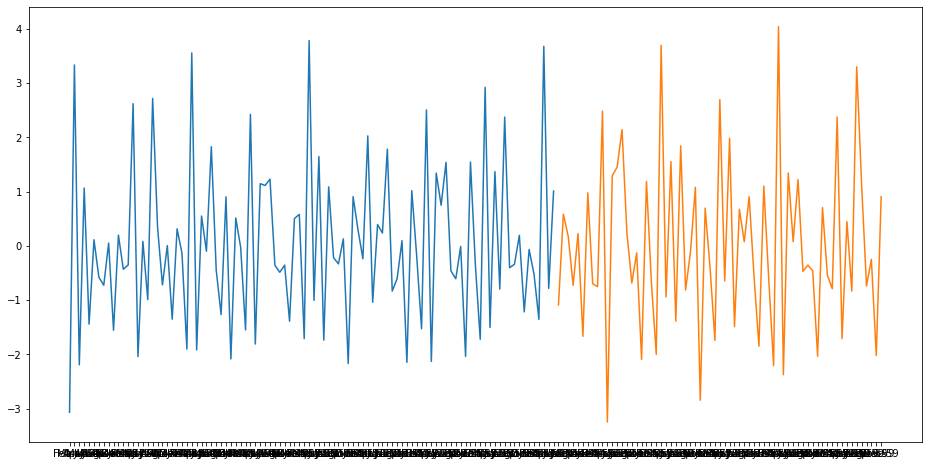

In [5]:
plt.figure(figsize=(16,8))
plt.plot( train['Counts'], label='Train')
plt.plot(test['Counts'], label='Test')


## Moving Average

In [6]:
width = 3
lag1 = df.shift(1)
lag3 = df.shift(width - 1)
window = lag3.rolling(window=width)
means = window.mean()
dataframe = pd.concat([means, lag1, df], axis=1)
dataframe.columns = ['mean', 't-1', 't+1']
print(dataframe.head(10))

               mean     t-1     t+1
Mon_Year                           
Jan-46          NaN     NaN  26.663
Feb-46          NaN  26.663  23.598
Mar-46          NaN  23.598  26.931
Apr-46          NaN  26.931  24.740
May-46    25.730667  24.740  25.806
Jun-46    25.089667  25.806  24.364
Jul-46    25.825667  24.364  24.477
Aug-46    24.970000  24.477  23.901
Sep-46    24.882333  23.901  23.175
Oct-46    24.247333  23.175  23.227


In [7]:
type(df)

pandas.core.frame.DataFrame

In [8]:
df = pd.DataFrame(df)

Test RMSE: 2.001


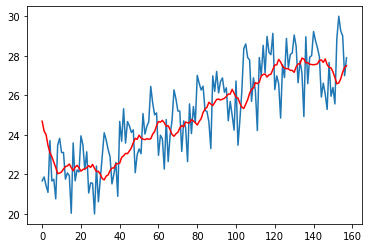

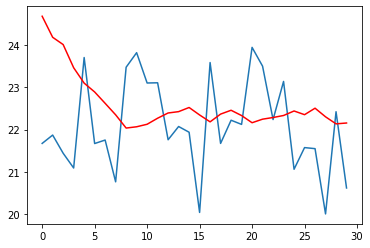

In [9]:
# prepare situation
X = df.Counts
window = 10
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()
# zoom plot
pyplot.plot(test[0:30])
pyplot.plot(predictions[0:30], color='red')
pyplot.show()

## ARIMA

                             ARIMA Model Results                              
Dep. Variable:               D.Counts   No. Observations:                  167
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -272.305
Method:                       css-mle   S.D. of innovations              1.234
Date:                Tue, 19 Jan 2021   AIC                            560.610
Time:                        09:25:16   BIC                            585.554
Sample:                    02-01-2046   HQIC                           570.734
                         - 12-01-2059                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0135      0.054      0.249      0.804      -0.093       0.120
ar.L1.D.Counts    -1.0413      0.265     -3.930      0.000      -1.561      -0.522
ar.L2.D.Counts    -0.2927      0.177

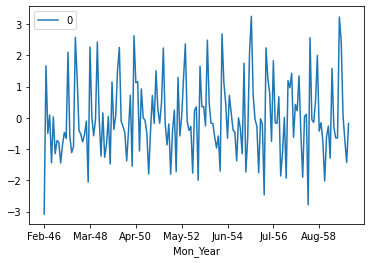

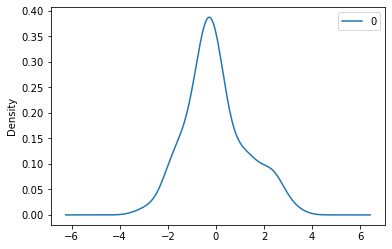

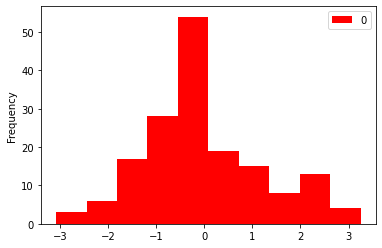

                0
count  167.000000
mean    -0.009590
std      1.245303
min     -3.078468
25%     -0.694148
50%     -0.172360
75%      0.693911
max      3.249700


In [10]:
x = df['Counts']
# fit model
model = ARIMA(x, order=(5,1,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())


rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

residuals.plot(kind = 'hist', color = 'red')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

<AxesSubplot:xlabel='Mon_Year'>

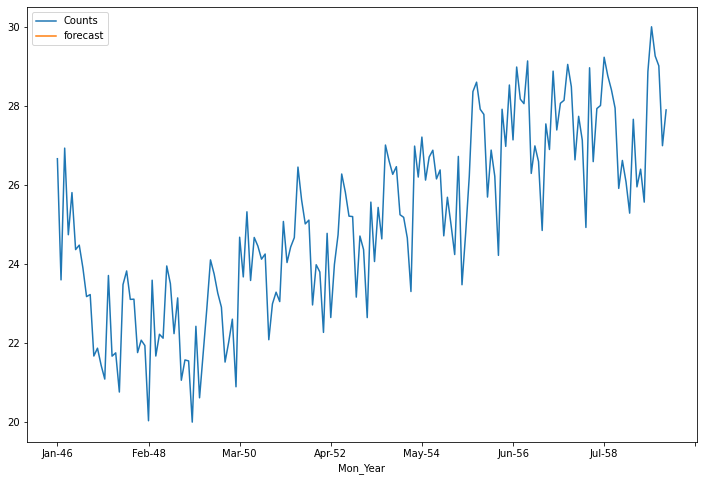

In [11]:
df['forecast']=model_fit.predict(start=100,end=168,dynamic=True)
df[['Counts','forecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Mon_Year'>

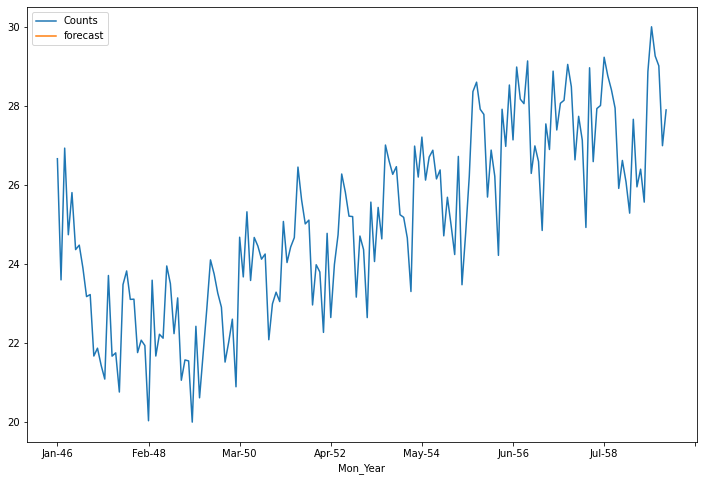

In [12]:
model=sm.tsa.statespace.SARIMAX(df['Counts'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
df['forecast']=results.predict(start=100,end=168,dynamic=True)
df[['Counts','forecast']].plot(figsize=(12,8))

In [15]:
res = sm.tsa.ARMA(df['Counts'], (1,1)).fit(disp=-1)
sm.stats.acorr_ljungbox(res.resid, lags=[2], return_df=True)

,lb_stat,lb_pvalue
2,9.154543,0.010283


In [16]:
# After 11 th lag the p_value is less than 0.05 so, we can reject the Ho. (The residuals are independently distributed.)

# H0: The residuals are independently distributed.

# HA: The residuals are not independently distributed; they exhibit serial correlation.

# Weighted Moving Average

In [17]:
train=df[0:100] 
test=df[100:168]

In [18]:
weights = np.arange(1,11) #this creates an array with integers 1 to 10 included
weights

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [19]:
wma10 = train['Counts'].rolling(10).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)
wma10.head(20)

Mon_Year
Jan-46          NaN
Feb-46          NaN
Mar-46          NaN
Apr-46          NaN
May-46          NaN
Jun-46          NaN
Jul-46          NaN
Aug-46          NaN
Sep-46          NaN
Oct-46    24.222145
Nov-46    23.673745
Dec-46    23.252091
Jan-47    22.783491
Feb-47    22.351109
Mar-47    22.461473
Apr-47    22.239055
May-47    22.080727
Jun-47    21.791764
Jul-47    22.054073
Aug-47    22.373582
Name: Counts, dtype: float64

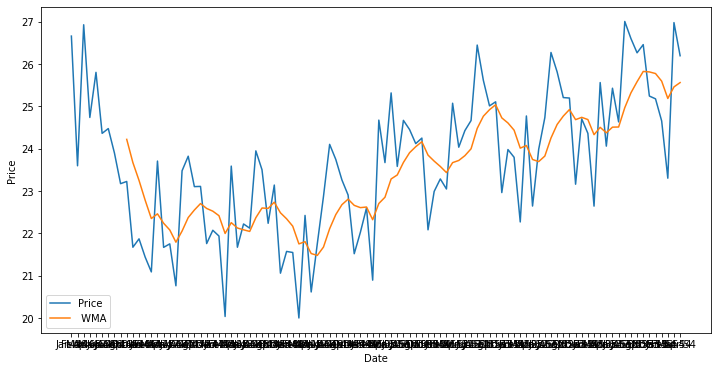

In [20]:
plt.figure(figsize = (12,6))
plt.plot(train['Counts'], label="Price")
plt.plot(wma10, label=" WMA")

plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

## Exponential Smoothening

In [21]:
train=df[0:100] 
test=df[100:168]

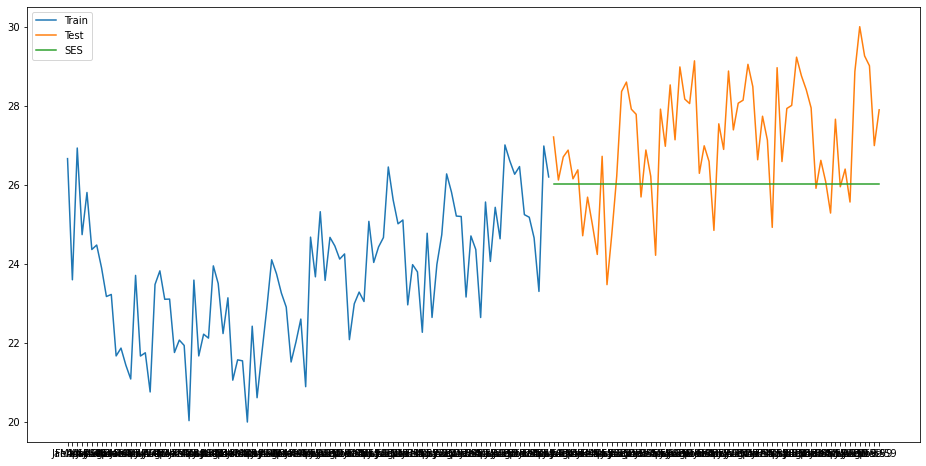

In [22]:
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Counts'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Counts'], label='Train')
plt.plot(test['Counts'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [23]:
rms = sqrt(mean_squared_error(test.Counts, y_hat_avg.SES))
print('RMSE:', rms)

RMSE: 1.796331318464765


### `Holt's Winter Method`

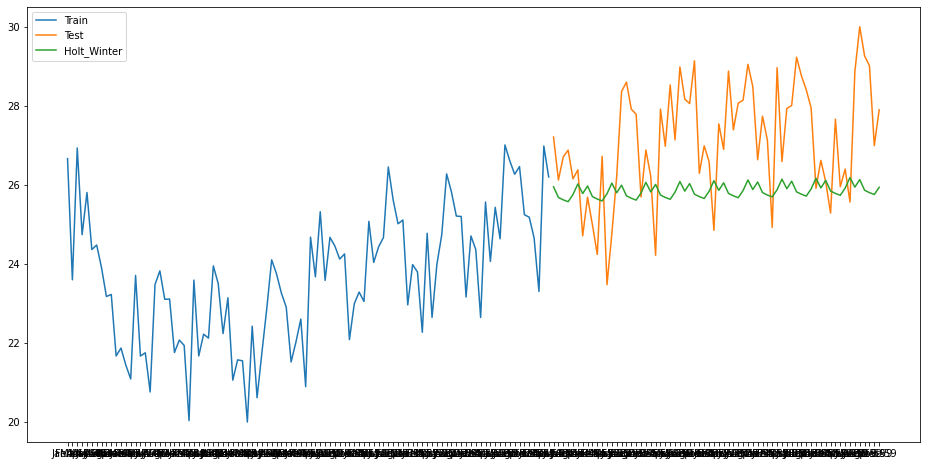

In [24]:
y_hat_avg = test.copy()
fit = ExponentialSmoothing(np.asarray(train['Counts']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['Counts'], label='Train')
plt.plot(test['Counts'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

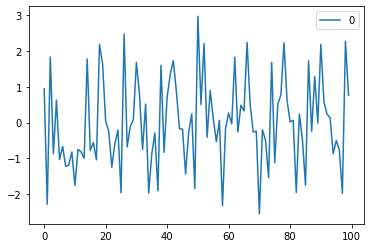

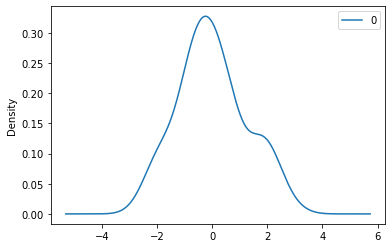

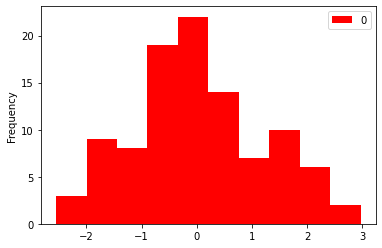

                0
count  100.000000
mean    -0.000035
std      1.236448
min     -2.549177
25%     -0.814055
50%     -0.163400
75%      0.729601
max      2.971910


In [25]:
residuals = pd.DataFrame(fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

residuals.plot(kind = 'hist', color = 'red')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [29]:
# ljungbox test

sm.stats.acorr_ljungbox(residuals, lags=[2], return_df=True)

,lb_stat,lb_pvalue
2,6.285404,0.043166


In [30]:
rms = sqrt(mean_squared_error(test.Counts, y_hat_avg.Holt_Winter))
print('RMSE:', rms)

RMSE: 1.913122948467036


In [31]:
y_hat_avg

,Counts,forecast,Holt_Winter
Mon_Year,,,
May-54,27.210,NaN,25.950219
Jun-54,26.122,NaN,25.681346
Jul-54,26.706,NaN,25.619834
Aug-54,26.878,NaN,25.573097
Sep-54,26.152,NaN,25.755052
...,...,...,...
Aug-59,30.000,NaN,26.132561
Sep-59,29.261,NaN,25.863688
Oct-59,29.012,NaN,25.802176


### `AUTO CORRELATION AND PARTIAL AUTO CORRELATION PLOT` 

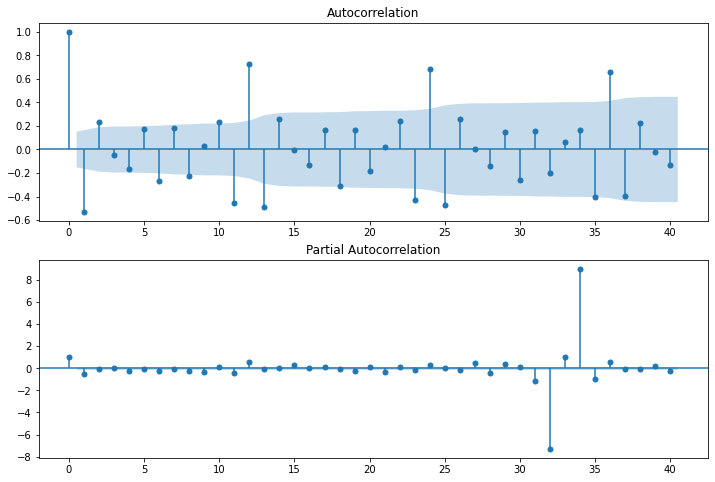

In [32]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_stationery['Counts'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_stationery['Counts'],lags=40,ax=ax2)

### `AUTO CORREALTION PLOT`

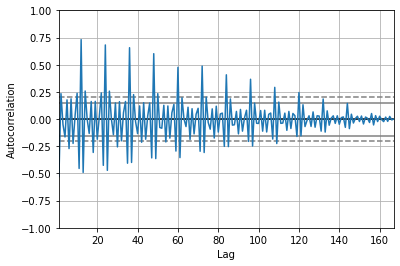

In [33]:
autocorrelation_plot(data_stationery['Counts'])
plt.show()